## https://tinyurl.com/ANLPColab3Part2
Go to "File" -> "Save a Copy in Drive..." This lets you create your own copy of the notebook in your Google drive, and any changes you make doesn't impact the shared notebook

# **TEXT CLASSIFICATION**

We are going to perform text classification to predict the output label from the IBM trust dataset. This notebook will showcase different ML algorithms and methods that can be employed to improve model performance.

## **Download the Data**

For ease of use, let's download the data set directly from the webpage and store it in a pandas dataframe.


In [1]:
#Read about the dataset here: https://research.ibm.com/haifa/dept/vst/debating_data.shtml
#The following dataset contains annotations of High trust, Low institutional trust and Low agent trust in user inputs to VIRA, a chatbot that aimes to address COVID-19 vaccine hesitancy (vaxchat.org)
!rm -r data/ # Remove pre-existing directories that might cause errors
!wget "https://www.research.ibm.com/haifa/dept/vst/files/IBM_Debater_(R)_trust_data.zip" # Download the data
!unzip *.zip # Unzip the zip files
!rm *.zip # Remove the zip files
!rm -r __MACOSX/ # Remove temp files

rm: cannot remove 'data/': No such file or directory
--2024-10-29 07:15:26--  https://www.research.ibm.com/haifa/dept/vst/files/IBM_Debater_(R)_trust_data.zip
Resolving www.research.ibm.com (www.research.ibm.com)... 13.32.151.2, 13.32.151.88, 13.32.151.71, ...
Connecting to www.research.ibm.com (www.research.ibm.com)|13.32.151.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://research.ibm.com/haifa/dept/vst/files/IBM_Debater_(R)_trust_data.zip [following]
--2024-10-29 07:15:26--  https://research.ibm.com/haifa/dept/vst/files/IBM_Debater_(R)_trust_data.zip
Resolving research.ibm.com (research.ibm.com)... 18.164.124.93, 18.164.124.73, 18.164.124.32, ...
Connecting to research.ibm.com (research.ibm.com)|18.164.124.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47231 (46K) [application/zip]
Saving to: ‘IBM_Debater_(R)_trust_data.zip’

IBM_Debater_(R)_tru 100%[===================>]  46.12K  --.-KB/s    in 0.07s

## **Load the Data**

In [ ]:
# Import the necessary libraries
import pandas as pd # Used to read and manipulate DataFrames

The dataset comes as three seperate files:
1. Train split - used to train and help the model learn the hidden features/patterns in the data
2. Validation split (dev) - used to validate our model's performance during the training process and helps tune the model's hyperparameters
3. Testing split - used to test the model *after* completing the training and provide unbiased final model performance metrics

In [ ]:
# Use panda's read_csv function to read the CSV files

df_train = pd.read_csv("data/train.csv")
df_val = pd.read_csv("data/dev.csv")
df_test = pd.read_csv("data/test.csv")

In [ ]:
#Generate descriptive statistics for the data set
df_train.describe()

,label
count,1815.000000
mean,1.622590
std,0.986254
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,3.000000


In [ ]:
# Use the DataFrame class's head() function to sneak a peek at the datasets
df_train.head()

,text,label
0,If symptomatic patient got the vaccine will he...,0
1,"Has anyone died from getting the Pfizer, Moder...",0
2,Why should I trust a pharmaceutical company wh...,0
3,What are antisense RNA's? Could they or dsRNA...,0
4,The vaccines aren't FDA approved.,0


In [ ]:
df_train.sample(5)

,text,label
282,what are the risks to be vaccinated ?,0
398,"Over 5000 veers deaths so far, how many to cal...",0
498,corona symptoms,2
681,Will vitamin C help with the vaccine side effe...,2
1551,Where did COVID start?,2


## **Text Preprocessing**

Before applying Machine Learning algorithms we should clean and pre-process the text data. We'll use popular pre-processing techniques we've used earlier:
1. Text cleaning - removal of unnecessary characters like symbols, urls, emojis etc.
2. Stopword removal - removal of words that don't convey any meaning to the machine
3. Stemming - transforming derived words into the root words, thus reducing the feature space


### Text Cleaning

In [ ]:
# Import the necessary libraries
import re # Regular expressions module
# Define pipeline function to perform multiple cleaning steps on a given text
def clean_text(text):
    text = text.lower() # Convert the text to lower case
    text = re.sub(r'[^\w]', ' ', text) # Remove symbols
    text = re.sub(r'[ ]{2,}', ' ', text) # Remove extra spaces
    text = re.sub(r'[ \t]+$', '', text) # Remove trailing white spaces
    return text

In [ ]:
# Apply the pipeline to the text column
df_train["text"] = df_train["text"].apply(clean_text)
df_val["text"] = df_val["text"].apply(clean_text)
df_test["text"] = df_test["text"].apply(clean_text)

In [ ]:
df_train.head()

,text,label
0,if symptomatic patient got the vaccine will he...,0
1,has anyone died from getting the pfizer modern...,0
2,why should i trust a pharmaceutical company wh...,0
3,what are antisense rna s could they or dsrna b...,0
4,the vaccines aren t fda approved,0


### Stopword Removal

In [ ]:
# Import the necessary libraries

import nltk # Text processing library that provides provides utility functions
nltk.download('stopwords') # Download the nltk's stopword module
from nltk.corpus import stopwords # Import the stopword module

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Function to remove stopwords
def remove_stopword(text):
    tokens = []
    stop_words = stopwords.words("english") # Obtain a set of english stopwords

    for token in text.split(): # Iterate over each word in the text
        if token not in stop_words: # Check is the word is not a stopword
            tokens.append(token) # Append to the token list

    return " ".join(tokens) # Join the tokens (with a " " as the seperator)

In [ ]:
# Apply the function to the text column
df_train["text"] = df_train["text"].apply(remove_stopword)
df_val["text"] = df_val["text"].apply(remove_stopword)
df_test["text"] = df_test["text"].apply(remove_stopword)

In [ ]:
df_train.head()

,text,label
0,symptomatic patient got vaccine dies,0
1,anyone died getting pfizer moderna johnson joh...,0
2,trust pharmaceutical company manipulate data,0
3,antisense rna could dsrna contaminating covid ...,0
4,vaccines fda approved,0


### Stemming

In [ ]:
# Import the necessary libraries
from nltk.stem import SnowballStemmer # Import the stemmer module from nltk

In [ ]:
# Function to perform stemming
def stem_words(text):
    tokens = []
    english_stemmer = SnowballStemmer("english") # Load the stemmer object

    for token in text.split(): # Iterate over each word in the text
        token = english_stemmer.stem(token) # Stem the word
        tokens.append(token) # Append to the token list

    return " ".join(tokens) # Join the tokens (with a " " as the seperator)

In [ ]:
# Apply the function to the text column
df_train["text"] = df_train["text"].apply(stem_words)
df_val["text"] = df_val["text"].apply(stem_words)
df_test["text"] = df_test["text"].apply(stem_words)

In [ ]:
df_train.head()

,text,label
0,symptomat patient got vaccin die,0
1,anyon die get pfizer moderna johnson johnson v...,0
2,trust pharmaceut compani manipul data,0
3,antisens rna could dsrna contamin covid mrna v...,0
4,vaccin fda approv,0


### Remove Empty Texts

In [ ]:
# Import the necessary libraries
import numpy as np # Used to manipulate and perform calculations on arrays/matrices

In [ ]:
# Train dataset
df_train["text"].replace("", np.nan, inplace=True) # Replace empty strings with NaN
df_train.dropna(subset=["text"], inplace=True) # Drop the NaNs from the text column
df_train.reset_index(inplace=True) # Reset the indexes
df_train.drop("index", axis="columns", inplace=True) # Drop the old index column

# Validation dataset
df_val["text"].replace("", np.nan, inplace=True) # Replace empty strings with NaN
df_val.dropna(subset=["text"], inplace=True) # Drop the NaNs from the text column
df_val.reset_index(inplace=True) # Reset the indexes
df_val.drop("index", axis="columns", inplace=True) # Drop the old index column

# Test dataset
df_test["text"].replace("", np.nan, inplace=True) # Replace empty strings with NaN
df_test.dropna(subset=["text"], inplace=True) # Drop the NaNs from the text column
df_test.reset_index(inplace=True) # Reset the indexes
df_test.drop("index", axis="columns", inplace=True) # Drop the old index column

## **Display Dataset Metrics**

In [ ]:
# The inbuilt function len() gives the total number of elements in a given object
print(f"Number of training data points = {len(df_train)}")
print(f"Number of validation data points = {len(df_val)}")
print(f"Number of testing data points = {len(df_test)}")


Number of training data points = 1805
Number of validation data points = 298
Number of testing data points = 903


In [ ]:
# NumPy's unique() function gives the unique elements of a given object
print(f"Number of classes = {len(np.unique(df_train['label']))}")
print(f"The class labels are = {np.unique(df_train['label'])}")

Number of classes = 4
The class labels are = [0 1 2 3]


In [ ]:
# Class metrics for training data

print("Training data")

# Restrictions/Selection can also be applied to the DataFrame objects
class_0 = df_train[df_train["label"] == 0] # Rows with the label as 0 are selected
class_1 = df_train[df_train["label"] == 1]
class_2 = df_train[df_train["label"] == 2]
class_3 = df_train[df_train["label"] == 3]

print(f"Number of Class 0 = {len(class_0)}")
print(f"Number of Class 1 = {len(class_1)}")
print(f"Number of Class 2 = {len(class_2)}")
print(f"Number of Class 3 = {len(class_3)}")

Training data
Number of Class 0 = 445
Number of Class 1 = 19
Number of Class 2 = 1117
Number of Class 3 = 224


In [ ]:
# Class metrics for validation data

print("Validation data")

class_0 = df_val[df_val["label"] == 0]
class_1 = df_val[df_val["label"] == 1]
class_2 = df_val[df_val["label"] == 2]
class_3 = df_val[df_val["label"] == 3]

print(f"Number of Class 0 = {len(class_0)}")
print(f"Number of Class 1 = {len(class_1)}")
print(f"Number of Class 2 = {len(class_2)}")
print(f"Number of Class 3 = {len(class_3)}")

Validation data
Number of Class 0 = 73
Number of Class 1 = 3
Number of Class 2 = 186
Number of Class 3 = 36


In [ ]:
# Class metrics for testing data

print("Testing data")

class_0 = df_test[df_test["label"] == 0]
class_1 = df_test[df_test["label"] == 1]
class_2 = df_test[df_test["label"] == 2]
class_3 = df_test[df_test["label"] == 3]

print(f"Number of Class 0 = {len(class_0)}")
print(f"Number of Class 1 = {len(class_1)}")
print(f"Number of Class 2 = {len(class_2)}")
print(f"Number of Class 3 = {len(class_3)}")

Testing data
Number of Class 0 = 223
Number of Class 1 = 9
Number of Class 2 = 559
Number of Class 3 = 112


## **Text Representation**

Input text should be represented in a numerical format for the machine to understand it, so our first step in feature engineering is to represent the text in another format.

There are many ways we can represent text data to apply machine learning:
1. Bag of Words (BoW): Represents text as a collection of individual words, ignoring grammar and word order
2. Term Frequency-Inverse Document Frequency (TF-IDF): Represents the importance of each word in the document and the corpus as a whole, based on its frequency in the document and its rarity in the corpus
3. Word Embeddings: Represents words as dense vectors in a high-dimensional space, where words with similar meanings are clustered together
4. Character-level Embeddings: Represents text at the character level, rather than the word level, using vectors to represent each character
5. Convolutional Neural Networks (CNNs): Learns features from text by applying convolutional filters to the text representation
6. Recurrent Neural Networks (RNNs): Models sequences of text, such as sentences or paragraphs, and can capture dependencies between words in a sentence
7. Transformer-based Models: Capture context and dependencies between words in a sentence using the attention mechanism

Here we shall make us of one of the more simpler and popular techniques: **TF-IDF**

In [ ]:
# Import the necessary libraries

import sklearn # Popular machine learning library
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf vectorizer module

In [ ]:
# First we need to append data from all the sets to create an entire corpus

# Create an empty array
X = np.array([], dtype=str)

# Append text from all the splits to the empty array
X = np.append(X, df_train["text"])
X = np.append(X, df_val["text"])
X = np.append(X, df_test["text"])

In [ ]:
vectorizer = TfidfVectorizer() # Load the tf-idf vectorizer from sklearn
vectorizer = vectorizer.fit(X) # Fit the vectorizer on the entire data

In [ ]:
# Extract the vocabulary from the vectorizer
vocab = vectorizer.vocabulary_
print(f"Number of terms in the vocabulary = {len(vocab)}")

Number of terms in the vocabulary = 1928


This means that there are 1928 unique tokens in our data set

In [ ]:
# Display a sample of the word => value mapping
print("Sample Mapping")
for idx, ele in enumerate(zip(vocab.keys(), vocab.values())):
    word, val = ele
    print(f"{word} => {val}")
    if idx == 4: break

Sample Mapping
symptomat => 1654
patient => 1263
got => 743
vaccin => 1797
die => 511


Now let's use the fitted vectorizer to transform the text in each data split into a sparsely populated matrix (Sparsely populated matrix because not every text contains the entire vocabulary but a small subset of it).

In [ ]:
# Transform the text for each data split and store it in a variable
X_train = vectorizer.transform(df_train["text"]).toarray()
X_val= vectorizer.transform(df_val["text"]).toarray()
X_test = vectorizer.transform(df_test["text"]).toarray()

In [ ]:
print(X_train) # The vector representation also known as a tf-idf matrix

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## **Label Encoding**

Similar to the text representation technique for input data, we also need a way to represent the target labels (for prediction).

Some popular label encoding techniques are:
1. Ordinal Encoding: Assigns a unique integer value to each category based on its order or rank
2. One-Hot Encoding: Creates a binary variable for each category, with a value of 1 for its corresponding category and 0 for all others
3. Binary Encoding: Similar to one-hot encoding, but uses binary values instead of 1s and 0s to reduce the number of variables required
4. Frequency Encoding: Assigns a numerical value to each category based on its frequency in the dataset
5. Target Encoding: Assigns a numerical value to each category based on the average of the target variable for that category

The labels in the dataset are already encoded using the Ordinal Encoding technique i.e. they exist as unique integers (0, 1, 2, 3). Let's proceed with this representation.

In [ ]:
# Extract the labels for each data split and store it in a variable
y_train = df_train["label"].to_numpy()
y_val = df_val["label"].to_numpy()
y_test = df_test["label"].to_numpy()


## **Predictive Models**
Now let's try different machine learning algorithms to predict our output labels from the text data. We'll be using the SKLearn implementations of the algorithms from Sci-kit learn package: https://scikit-learn.org/stable/.

### Logistic Regression

Logistic Regression is a statistical technique used to model the relationship between a binary dependent variable and one or more independent variables. It estimates the probability of occurrence of a binary event based on the given set of independent variables. It uses a sigmoid function to map any real-valued input to a probability value between 0 and 1.

In [ ]:
# Import the necessary libraries

from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.metrics import classification_report # Module to calculate performance metrics
from sklearn.metrics import confusion_matrix # Module to calculate the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay # Module to display the confusion matrix

import matplotlib.pyplot as plt # Module to help draw the confusion matrix

In [ ]:
# Load the model
lr_model = LogisticRegression()

# Fit the model
lr_model.fit(X=X_train, y=y_train)

# Obtain the predictions for the validation data
pred_val = lr_model.predict(X_val)

# Get the classification report for the prediction
# It is a dictionary that contains various metrics and their values
# We choose accuracy and weighted average f1-score as our metrics of choice
results = classification_report(y_true=y_val, y_pred=pred_val, output_dict=True, zero_division=0) # Use zero_devision to control warnings

print(f"Accuracy = {results['accuracy']*100:>.2f} %")
print(f"Weighted Avg F1-score = {results['weighted avg']['f1-score']:>.4f}")

Accuracy = 77.18 %
Weighted Avg F1-score = 0.7582


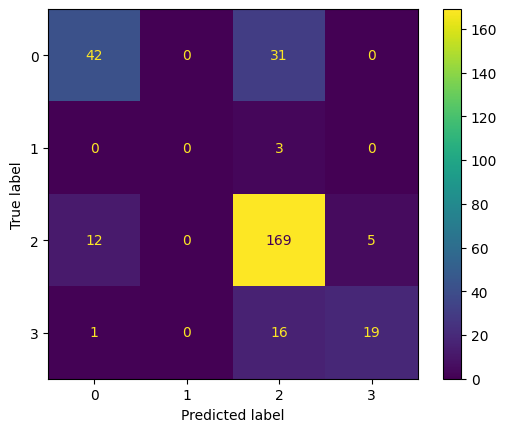

In [ ]:
# Obtain the confusion matrix
cm = confusion_matrix(y_val, pred_val)

# Uncomment the following line to just print the matrix to the standard output
# print(cm)

cm_display = ConfusionMatrixDisplay(cm) # Initiate a ConfusionMatrixDisplay object
cm_display.plot() # Plot the object
plt.show() # Display the plot

### Decision Tree

A decision tree model is a type of supervised learning algorithm used to solve both classification and regression problems. It splits the dataset into smaller subsets based on the most significant features of the data, recursively creating a tree structure until a leaf node (a final decision) is reached.

In [ ]:
# Import the necessary libraries

from sklearn.tree import DecisionTreeClassifier # Decision Tree Model for Classification

In [ ]:
# Load the model
dt_model = DecisionTreeClassifier()

# Fit the model
dt_model.fit(X=X_train, y=y_train)

# Obtain the predictions for the validation data
pred_val = dt_model.predict(X_val)

# Get the classification report for the prediction
# It is a dictionary that contains various metrics and their values
# We choose accuracy and weighted average f1-score as our metrics of choice
results = classification_report(y_true=y_val, y_pred=pred_val, output_dict=True, zero_division=0) # Use zero_devision to control warnings

print(f"Accuracy = {results['accuracy']*100:>.2f} %")
print(f"Weighted Avg F1-score = {results['weighted avg']['f1-score']:>.4f}")

Accuracy = 77.85 %
Weighted Avg F1-score = 0.7778


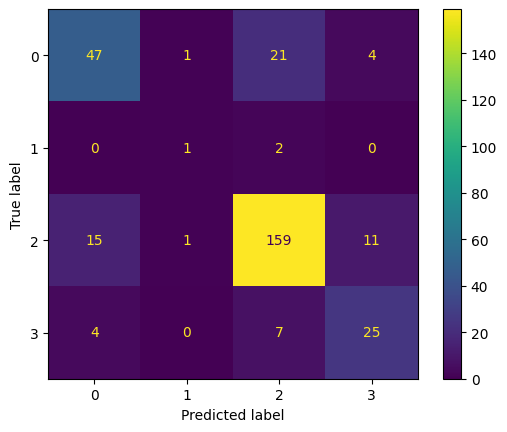

In [ ]:
# Obtain the confusion matrix
cm = confusion_matrix(y_val, pred_val)

# Uncomment the following line to just print the matrix to the standard output
# print(cm)

cm_display = ConfusionMatrixDisplay(cm) # Initiate a ConfusionMatrixDisplay object
cm_display.plot() # Plot the object
plt.show() # Display the plot

### Support Vector Machine

Support Vector Machine (SVM) are a type of supervised learning algorithm used for classification, regression, and outlier detection. They find a hyperplane that separates classes in a high-dimensional space by maximizing the margin between the two classes.

In [ ]:
# Import the necessary libraries

from sklearn.svm import SVC # Support Vector Machine for Classification

In [ ]:
# Load the model
svc_model = SVC()

# Fit the model
svc_model.fit(X=X_train, y=y_train)

# Obtain the predictions for the validation data
pred_val = svc_model.predict(X_val)

# Get the classification report for the prediction
# It is a dictionary that contains various metrics and their values
# We choose accuracy and weighted average f1-score as our metrics of choice
results = classification_report(y_true=y_val, y_pred=pred_val, output_dict=True, zero_division=0) # Use zero_devision to control warnings

print(f"Accuracy = {results['accuracy']*100:>.2f} %")
print(f"Weighted Avg F1-score = {results['weighted avg']['f1-score']:>.4f}")

Accuracy = 78.52 %
Weighted Avg F1-score = 0.7714


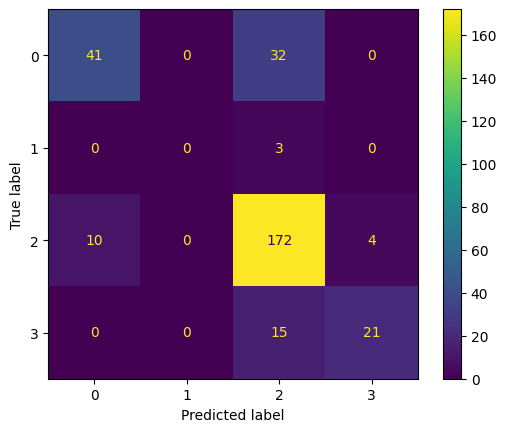

In [ ]:
# Obtain the confusion matrix
cm = confusion_matrix(y_val, pred_val)

# Uncomment the following line to just print the matrix to the standard output
# print(cm)

cm_display = ConfusionMatrixDisplay(cm) # Initiate a ConfusionMatrixDisplay object
cm_display.plot() # Plot the object
plt.show() # Display the plot

## **Model Comparison**

### Testing Data

After training the models using the training set and validating them during training using validation set, now we compare the models using the testing set.

In [ ]:
print("Model \t Accuracy \t Weighted Avg F1-score")
print("-----------------------------------------------")

# Logistic Regression
pred_test = lr_model.predict(X_test)
results = classification_report(y_true=y_test, y_pred=pred_test, output_dict=True, zero_division=0)
print(f"LR \t {results['accuracy']*100:>.2f} % \t {results['weighted avg']['f1-score']:>.4f}")

# Decision Tree
pred_test = dt_model.predict(X_test)
results = classification_report(y_true=y_test, y_pred=pred_test, output_dict=True, zero_division=0)
print(f"DT \t {results['accuracy']*100:>.2f} % \t {results['weighted avg']['f1-score']:>.4f}")

# Support Vector Machine
pred_test = svc_model.predict(X_test)
results = classification_report(y_true=y_test, y_pred=pred_test, output_dict=True, zero_division=0)
print(f"SVM \t {results['accuracy']*100:>.2f} % \t {results['weighted avg']['f1-score']:>.4f}")

Model 	 Accuracy 	 Weighted Avg F1-score
-----------------------------------------------
LR 	 75.19 % 	 0.7271
DT 	 77.08 % 	 0.7678
SVM 	 76.63 % 	 0.7450


We can observe that the Decision tree model performs the best for our data set (F1-score = 0.77). One caveat with DT is that they might overfit the input data.

### Cross Validation

Cross-validation is a statistical method used to assess and evaluate how well a machine learning model generalizes to new data. It involves dividing the dataset into several subsets or folds, training the model on a subset, and evaluating its performance on the remaining subset. This process is repeated multiple times, with different subsets used for training and evaluation, and the results are averaged to provide an estimate of the model's performance. This makes sure that our model does not perform well on our test set by accident!

Here we are going to perform K Fold cross validation with K set to 5 so that the data is split into 5 different sets.

In [ ]:
# Import the necessary libraries

from sklearn.model_selection import KFold # Module for k-fold cross validation

In [ ]:
# Before performing cross validation we need to combine the data splits into a single entity

X = np.array([], dtype=str) # Create an empty array

# Append text from all the splits to the empty array
X = np.append(X, df_train["text"])
X = np.append(X, df_val["text"])
X = np.append(X, df_test["text"])

print(f"Shape of X = {X.shape}")

Shape of X = (3006,)


In [ ]:
# Now we need to vectorize the texts
X = vectorizer.transform(X)
print(f"Shape of X = {X.shape}")

Shape of X = (3006, 1928)


In [ ]:
# Combine all the labels

y = np.array([]) # Create an empty array

# Append labels from all the splits to the empty array
y = np.append(y, df_train["label"])
y = np.append(y, df_val["label"])
y = np.append(y, df_test["label"])

print(f"Shape of y = {y.shape}")

Shape of y = (3006,)


In [ ]:
# Initialize a KFold object, let's use 5 splits
cross_val = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
print("Model \t Accuracy \t Weighted Avg F1-score")
print("-----------------------------------------------")



# Logistic Regression
pred = np.array([]) # Create an empty array to store the predictions
targets = np.array([]) # Create an empty array to store the targets

for train_idx, test_idx in cross_val.split(X): # Iterate over each split
    # Extract the train and test data for the current split
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LogisticRegression() # Load the model
    model.fit(X=X_train, y=y_train) # Fit the model
    pred_test = model.predict(X_test) # Obtain the predictions for the validation data

    # Append the predictions and targets
    pred = np.append(pred, pred_test)
    targets = np.append(targets, y_test)

# Calculate and print the results
results = classification_report(y_true=targets, y_pred=pred, output_dict=True, zero_division=0)
print(f"LR \t {results['accuracy']*100:>.2f} % \t {results['weighted avg']['f1-score']:>.4f}")



# Decision Tree
pred = np.array([]) # Create an empty array to store the predictions
targets = np.array([]) # Create an empty array to store the targets

for train_idx, test_idx in cross_val.split(X): # Iterate over each split
    # Extract the train and test data for the current split
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = DecisionTreeClassifier() # Load the model
    model.fit(X=X_train, y=y_train) # Fit the model
    pred_test = model.predict(X_test) # Obtain the predictions for the validation data

    # Append the predictions and targets
    pred = np.append(pred, pred_test)
    targets = np.append(targets, y_test)

# Calculate and print the results
results = classification_report(y_true=targets, y_pred=pred, output_dict=True, zero_division=0)
print(f"DT \t {results['accuracy']*100:>.2f} % \t {results['weighted avg']['f1-score']:>.4f}")



# Support Vector Machine
pred = np.array([]) # Create an empty array to store the predictions
targets = np.array([]) # Create an empty array to store the targets

for train_idx, test_idx in cross_val.split(X): # Iterate over each split
    # Extract the train and test data for the current split
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = SVC() # Load the model
    model.fit(X=X_train, y=y_train) # Fit the model
    pred_test = model.predict(X_test) # Obtain the predictions for the validation data

    # Append the predictions and targets
    pred = np.append(pred, pred_test)
    targets = np.append(targets, y_test)

# Calculate and print the results
results = classification_report(y_true=targets, y_pred=pred, output_dict=True, zero_division=0)
print(f"SVM \t {results['accuracy']*100:>.2f} % \t {results['weighted avg']['f1-score']:>.4f}")

Model 	 Accuracy 	 Weighted Avg F1-score
-----------------------------------------------
LR 	 77.01 % 	 0.7534
DT 	 75.98 % 	 0.7557
SVM 	 77.61 % 	 0.7606


Both DT and SVM seem to exhibit comparable results (SVM probably generalises better to new unseen data!)

## **Appendix**

This section contains techniques and code that might be useful while training models for text classification. Try these on your own (and explore more).

### Hyper Parameter Tuning

The models we used all have various paramaters that can be tuned to various degrees and might result in varying levels of performance. Ideally we want to find the best parameters for our use case. One technique for hyper parameter tuning is called **GridSearch**. This technique runs an exhaustive search over all the parameters to find the best set.

Let's try out the GridSearch technique on the Decision Tree Model

In [ ]:
# Import the necessary libraries

from sklearn.model_selection import GridSearchCV # Module for GridSearch

In [ ]:
# Code to silence the warnings generated by GridSearch
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Grid Search

# Define the different parameters over which the algorithm should search
parameters = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_features": ["auto", "sqrt", "log2", None],
}

# Load the model
model = DecisionTreeClassifier()

# Initialize the GridSearch object
grid_search = GridSearchCV(model, parameters, n_jobs=-1, scoring='f1_weighted')
# Perform the search
gs = grid_search.fit(X, y)

# Display the best parameters
grid_search.best_params_

{'criterion': 'entropy', 'max_features': None, 'splitter': 'random'}

Now we shall see how this model with the fine-tuned parameters compares with the default model using cross validation

In [ ]:
# Initialize a KFold object
cross_val = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
print("Model \t Accuracy \t Weighted Avg F1-score")
print("-----------------------------------------------")



# Decision Tree
pred = np.array([]) # Create an empty array to store the predictions
targets = np.array([]) # Create an empty array to store the targets

for train_idx, test_idx in cross_val.split(X): # Iterate over each split
    # Extract the train and test data for the current split
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = DecisionTreeClassifier() # Load the model
    model.fit(X=X_train, y=y_train) # Fit the model
    pred_test = model.predict(X_test) # Obtain the predictions for the validation data

    # Append the predictions and targets
    pred = np.append(pred, pred_test)
    targets = np.append(targets, y_test)

# Calculate and print the results
results = classification_report(y_true=targets, y_pred=pred, output_dict=True, zero_division=0)
print(f"DT \t {results['accuracy']*100:>.2f} % \t {results['weighted avg']['f1-score']:>.4f}")



# Decision Tree (tuned)
pred = np.array([]) # Create an empty array to store the predictions
targets = np.array([]) # Create an empty array to store the targets

for train_idx, test_idx in cross_val.split(X): # Iterate over each split
    # Extract the train and test data for the current split
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Load the model with the best hyper parameters
    model = DecisionTreeClassifier(criterion="gini", max_features=None, splitter="random")
    model.fit(X=X_train, y=y_train) # Fit the model
    pred_test = model.predict(X_test) # Obtain the predictions for the validation data

    # Append the predictions and targets
    pred = np.append(pred, pred_test)
    targets = np.append(targets, y_test)

# Calculate and print the results
results = classification_report(y_true=targets, y_pred=pred, output_dict=True, zero_division=0)
print(f"DTt \t {results['accuracy']*100:>.2f} % \t {results['weighted avg']['f1-score']:>.4f}")

Model 	 Accuracy 	 Weighted Avg F1-score
-----------------------------------------------
DT 	 76.31 % 	 0.7594
DTt 	 76.88 % 	 0.7655


We have improved the decision tree model's performance by tuning its hyper parameters. Try others on your own!